In [2]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
%matplotlib inline
path = '.\\BaselineImages'
list_image_files = os.listdir(path)

# 1. Introduction
On the Moonboard website there are a set of "baseline" problems, believed to be set and reviewed, so that they are the correct grade. These problems could be more consistent and better modelled through a regression algorithm, as they will have been reviewed, and so the grade should be more accurate.

# 2. Conversion to V-Grades

In [9]:
# get original scraped data from web
data=pd.read_excel('BaselineProblems.xlsm',sheetname='Data')
data.head()

,Name,Grade,Hyperlink,FileName
0,#222 DYNAMIC STRETCH (3Q),6B+,https://www.moonboard.com/Problems/View/312855...,0.png
1,1 ARM MADNESS (MBMASTERS),8A+,https://www.moonboard.com/Problems/View/308170...,1.png
2,32.2 MILES,6C,https://www.moonboard.com/Problems/View/315586...,2.png
3,52KIMCHI,7C+,https://www.moonboard.com/Problems/View/316811...,3.png
4,7B THEY SAID...,7A,https://www.moonboard.com/Problems/View/308629...,4.png


In [10]:
# get conversion from font to v-grade scale
conversion=pd.read_excel('Moon2017_40degrees_test.xlsx',sheetname='Conversion')
conversion.head(4)

,V_Grade,Font_Grade
0,0,4
1,0,4+
2,1,5
3,2,6A


In [11]:
# Add V-grades to the dataframe
m,n = data.shape
v_grades = np.array([int(conversion[conversion['Font_Grade']==x]['V_Grade']) for x in data['Grade']])
data['V_Grades'] = v_grades
data.head()

,Name,Grade,Hyperlink,FileName,V_Grades
0,#222 DYNAMIC STRETCH (3Q),6B+,https://www.moonboard.com/Problems/View/312855...,0.png,5
1,1 ARM MADNESS (MBMASTERS),8A+,https://www.moonboard.com/Problems/View/308170...,1.png,12
2,32.2 MILES,6C,https://www.moonboard.com/Problems/View/315586...,2.png,5
3,52KIMCHI,7C+,https://www.moonboard.com/Problems/View/316811...,3.png,10
4,7B THEY SAID...,7A,https://www.moonboard.com/Problems/View/308629...,4.png,6


# 3. Identify number of Holds
- Scraped data is formatted and saved into new excel workbook.
- Amount of holds is identified of each type for each image

In [12]:
def hold_identify(path,image_name):
    """Function takes in path and image name and returns red,green,blue holds
    Parameters
    ----------
    path : string
        path of image file
    image_name : string
        image file name
    Returns
    ----------
    [red,green,blue] : list of ints
        red holds, green holds, blue holds
    """
    imag = Image.open("{0}\\{1}".format(path,image_name))
    image_array = np.array(imag.getdata())
    red = image_array[(image_array[:,0]==255)&(image_array[:,1]==0)&(image_array[:,2]==0)&(image_array[:,3]==255),:].shape
    red = red[0]
    red = int(red/1050)
    green = image_array[(image_array[:,0]==0)&(image_array[:,1]==255)&(image_array[:,2]==0)&(image_array[:,3]==255),:].shape
    green = green[0]
    green = int(green/1050)
    blue = image_array[(image_array[:,0]==0)&(image_array[:,1]==0)&(image_array[:,2]==255)&(image_array[:,3]==255),:].shape
    blue = blue[0]
    blue = int(blue/1050)
    #print(list_image_files[i])
    #print('Red: {0},Green: {1},Blue: {2}'.format(red,green,blue))
    return [red,green,blue]

In [13]:
# create an array of all the rgb holds
rgb_array=[]
for image in data['FileName']:
    imag = '{0}'.format(image)
    rgb_array.append(hold_identify(path,imag))
rgb_array=np.array(rgb_array)
print('run')
# Add hold information to the dataframe
data['red']=rgb_array[:,0]
data['green']=rgb_array[:,1]
data['blue']=rgb_array[:,2]
data.head()
# save to excel
data.to_excel('BaselineProblems.xlsm')

run


# 4. Initial Data Summary
- reload formatted data
- histogram & boxplot of data

In [14]:
data = pd.read_excel('BaselineProblems.xlsm')

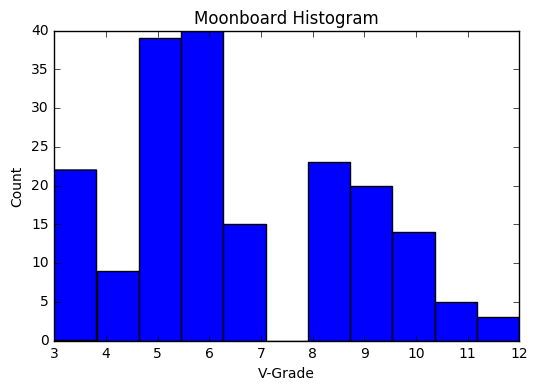

In [15]:
plt.hist(data['V_Grades'],bins=11)
plt.title('Moonboard Histogram')
plt.xlabel('V-Grade')
plt.ylabel('Count')
plt.show()

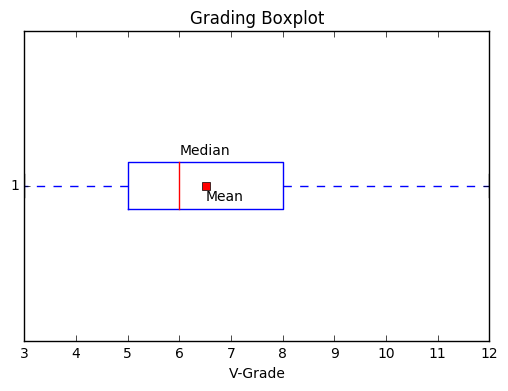

In [16]:
grade_mean = np.mean(data['V_Grades'])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(data['V_Grades'],vert=False,showfliers=False,showmeans=True)
plt.title('Grading Boxplot')
plt.xlabel('V-Grade')
ax.annotate('Median',(np.median(data['V_Grades']),1.1))
ax.annotate('Mean',(grade_mean,0.95))
plt.show()

Difficulty of problems is not normally distributed. It is right tailed. This is unsurprising, as the entry levelfor training on a moon board is quite high, and there are no lower grade problems. We see two particular peaks in the histogram. The first around the lowest level that people are setting (V3). The second around the point that most individuals are training at (V6). What should be noted is that users may often "try out" the moonboard, setting problems at a lower grade, rather than consistently using and training on it. This leads to a large spike around the low end. If these were to be disregarded then there would be a more normally distributed range of grades.

# 5. Additional Features Identification
- Find key statistics for the problem (min distance, max distance, mean distance, median distance, range of distances, min & max angle between holds, mean angle)

# 5.1 Data extraction function
- Constructing an algorithm to extract key info

In [17]:
def get_image_data(path,image_name,hold_number):
    """
    Parameters
    -----------
    path : folder of file location
    image_name : file name image
    Returns
    -----------
    stat_arr : array of statistical data in the format:
    max_distance,mean_distance,std_distance,mean_angle"""
    # step 1 load image
    image_open = Image.open("{0}\\{1}".format(path,image_name))
    image_data = np.array(image_open.getdata())
    # create relevant dictionaries for colours
    rgb_dic = {'red' : [255,0,0,255],'green' : [0,255,0,255],'blue' : [0,0,255,255]}
    # step 2 create binary array of image
    image_binary = np.zeros(len(image_data))
    for key in rgb_dic.keys():
        image_binary[(image_data[:,0]==rgb_dic[key][0])&(image_data[:,1]==rgb_dic[key][1])&(image_data[:,2]==rgb_dic[key][2]) & (image_data[:,3]==rgb_dic[key][3])]=1
    image_binary  = image_binary.reshape(image_open.height,image_open.width)
    # step 3 locate centre of each cluster
    # fit the pixel locations to a KMeans clustering model to find centre points
    y,x=np.where(image_binary==1)
    m=x.size
    x=x.reshape(m,1)
    y=y.reshape(m,1)
    YX=np.concatenate((y,x),axis=1)
    hold_kmeans=KMeans(n_clusters=hold_number)
    hold_kmeans.fit(YX)
    hold_ctr = hold_kmeans.cluster_centers_
    # invert the height
    hold_ctr[:,0]=1000-hold_ctr[:,0]
    # sort by height
    hold_ctr = hold_ctr[hold_ctr[:,0].argsort()]
    # step 4 find distances and angles between each consecutive cluster (hold)
    height,width = hold_ctr.shape
    distance_l = []
    angle_l = []
    for h in range(height-1):
        first = hold_ctr[h,:]
        second = hold_ctr[h+1,:]
        fs=np.abs(second-first)
        o=fs[0]
        a=fs[1]
        distance = np.sqrt(o**2+a**2)
        angle = np.degrees(np.arctan(o/a))
        distance_l.append(distance)
        angle_l.append(angle)
    # step 5 output statistics
    #max_distance,mean_distance,std_distance,mean_angle
    stat_arr = np.array([[np.max(distance_l),np.mean(distance_l),np.std(distance_l),np.mean(angle_l)]])
    return stat_arr

# 5.3 Data Extraction run

In [18]:
data['total_holds']=np.sum(data[['red','green','blue']],axis=1)

In [19]:
# set index of data so that can easily select and join with other data later
data=data.set_index('FileName')

In [20]:
# Loop through all entries from data  and apply algorithm to find max/mean/std data
first = True
for name in data.index:
    hold_number = int(data[data.index==name]['total_holds'])
    result = get_image_data(path,name,hold_number)
    result = np.concatenate((np.array([[name]]),result),axis=1)
    if first == True:
        result_arr = result
        first = False
    else:
        result_arr = np.concatenate((result_arr,result),axis=0)
print('Result array constructed')

C:\Users\Frank\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: divide by zero encountered in double_scalars


Result array constructed


In [21]:
result_df = pd.DataFrame(result_arr,columns=['Image_Name','Max_dist','Mean_dist','Std_dist','Mean_angle'])

In [22]:
result_df.head()

,Image_Name,Max_dist,Mean_dist,Std_dist,Mean_angle
0,0.png,290.5497706841365,187.42334809081925,64.36496328186672,48.112716453490656
1,1.png,349.9999999999924,209.75466832001243,94.87630051753439,56.530663195426676
2,2.png,290.49790341658223,212.3829894244618,74.0228708406103,37.28044439364162
3,3.png,321.4415456589437,183.5585141452697,84.7204115377759,37.25156964433805
4,4.png,268.50348723784697,183.7135427068991,68.64844994560245,26.573449328726475


In [23]:
# set the indexes to match
result_df=result_df.set_index(data.index)
# drop the now unused Image_Name column from our data frame
result_df = result_df.drop('Image_Name',axis=1)
# concatenate the two dataframes together
data=pd.concat((data,result_df),axis=1)

In [24]:
data.head()

,Name,Grade,Hyperlink,V_Grades,red,green,blue,total_holds,Max_dist,Mean_dist,Std_dist,Mean_angle
FileName,,,,,,,,,,,,
0.png,#222 DYNAMIC STRETCH (3Q),6B+,https://www.moonboard.com/Problems/View/312855...,5,1,2,4,7,290.5497706841365,187.42334809081925,64.36496328186672,48.112716453490656
1.png,1 ARM MADNESS (MBMASTERS),8A+,https://www.moonboard.com/Problems/View/308170...,12,1,2,3,6,349.9999999999924,209.75466832001243,94.87630051753439,56.530663195426676
2.png,32.2 MILES,6C,https://www.moonboard.com/Problems/View/315586...,5,1,2,4,7,290.49790341658223,212.3829894244618,74.0228708406103,37.28044439364162
3.png,52KIMCHI,7C+,https://www.moonboard.com/Problems/View/316811...,10,1,2,4,7,321.4415456589437,183.5585141452697,84.7204115377759,37.25156964433805
4.png,7B THEY SAID...,7A,https://www.moonboard.com/Problems/View/308629...,6,1,2,6,9,268.50348723784697,183.7135427068991,68.64844994560245,26.573449328726475


In [26]:
# save the data to excel
data.to_excel('BaselineProblems.xlsm')

# 6. Feature Clustering
- Do climbs cluster by a set of features
- Do these features align at all with climbing grade?

In [27]:
data=pd.read_excel('BaselineProblems.xlsm')
# How many grades are there to potentially cluster around?
grade_number = pd.unique(data['V_Grades']).size
print(grade_number)
# We will use a subset of features: total_holds, Max_dist, Mean_dist, Std_dist, Mean_angle
training_df = data[['total_holds','Max_dist','Mean_dist','Std_dist','Mean_angle']]
training_grade_df = data['V_Grades']
training_df.head()

10


,total_holds,Max_dist,Mean_dist,Std_dist,Mean_angle
0,7,290.549771,187.423348,64.364963,48.112716
1,6,350.000000,209.754668,94.876301,56.530663
2,7,290.497903,212.382989,74.022871,37.280444
3,7,321.441546,183.558514,84.720412,37.251570
4,9,268.503487,183.713543,68.648450,26.573449


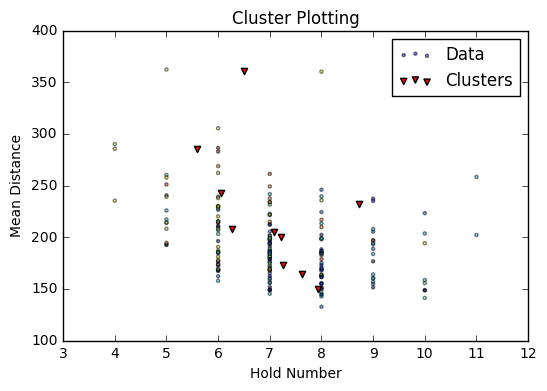

In [28]:
# fit and graph model
clustering_model = KMeans(n_clusters=grade_number)
clustering_model.fit(training_df)
cluster_ctr = clustering_model.cluster_centers_
plt.scatter(training_df['total_holds'],training_df['Mean_dist'],c=training_grade_df/100,marker='.',alpha=0.5)
plt.legend()
plt.scatter(cluster_ctr[:,0],cluster_ctr[:,2],c='r',marker='v')
plt.legend(['Data','Clusters'])
plt.title('Cluster Plotting')
plt.ylabel('Mean Distance')
plt.xlabel('Hold Number')

plt.show()

# 7. Logistic Regression
- Can a logistic regression be used to suitably predict grades based on the data?

# 7.1 Training

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
logistic_regression = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(training_df, training_grade_df, test_size=0.33, random_state=42)

In [31]:
logistic_regression.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
prediction = logistic_regression.predict(X_test)

# 7.2 Results
Accuracy score of only 28.5%.This is lower than our first training set. 

In [33]:
accuracy_score(y_test,prediction)

0.2857142857142857

# 8. KNeighbors
- Going to attempt to create a prediction model based on the K Nearest Neighbors algorithm
- Will attempt to identify the most accurate level of recommendation

# 8.1 Model Training
- Using the elbow method will attempt to identify the best K number to use

In [49]:
data=pd.read_excel('BaselineProblems.xlsm')
# We will use a subset of features: total_holds, Max_dist, Mean_dist, Std_dist, Mean_angle
training_df = data[['total_holds','Max_dist','Mean_dist','Std_dist','Mean_angle']]
training_grade_df = data['V_Grades']
X_train, X_test, y_train, y_test = train_test_split(training_df, training_grade_df, test_size=0.33, random_state=42)
training_df.head()

,total_holds,Max_dist,Mean_dist,Std_dist,Mean_angle
0,7,290.549771,187.423348,64.364963,48.112716
1,6,350.000000,209.754668,94.876301,56.530663
2,7,290.497903,212.382989,74.022871,37.280444
3,7,321.441546,183.558514,84.720412,37.251570
4,9,268.503487,183.713543,68.648450,26.573449


In [50]:
from sklearn.neighbors import KNeighborsClassifier

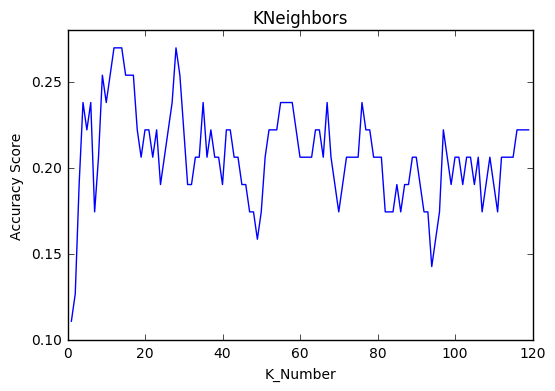

In [51]:
# Going to use the elbow method to see if we can identify the most accurate number of neighbors
k_range = np.arange(1,120)
accuracy_list = []
for k in k_range:
    KN_model = KNeighborsClassifier(n_neighbors=k)
    KN_model.fit(X_train,y_train)
    KN_prediction = KN_model.predict(X_test)
    accuracy_list.append(accuracy_score(y_test,KN_prediction))
plt.title('KNeighbors')
plt.xlabel('K_Number')
plt.ylabel('Accuracy Score')
plt.plot(k_range,accuracy_list)
plt.show()

# 8.2 Result
Accuracy generally lower and very inconsistent. Elbow method maxes out at about 11 and then drops off. Due to the lower amount of data it is unsurprising that the K_Number is lower.

In [52]:
print('maximum accuracy: {0}'.format(round(np.max(accuracy_list),6)))
print('Best K Neighbors: {0}'.format(np.argmax(accuracy_list)))

maximum accuracy: 0.269841
Best K Neighbors: 11


# 8.3 Next Steps
Possible improvements to the model could be made by looking at hold type/quality. Holds could be defined as white/black/red/yellow. Does use of one hold type more than others also weight a climb to a certain difficulty?

1. Identify holds position, graph them to ensure that they do not overlap.
2. Offset background, so image clustering isn't affected.
3. Split Image into sub-images, find centre points. Average the sub-image pixels.
4. Cluster images by average pixel of each sub-image.
5. Check results
6. Add this to the stored data

In [39]:
# Load Image
image_file = 'base_image.png'
image_open = Image.open('{0}'.format(image_file),'r')
image_array = np.array(image_open)
n,m = image_open.size
image_open.close()
image_array = image_array.reshape((m*n,4))
image_array = image_array.astype('uint8')

# 8.3.1 Identify Hold Position
Manual investigation shows that each hold position is around 50x50 pixels in shape. The image can therefore be split into sub-images of 50x50.

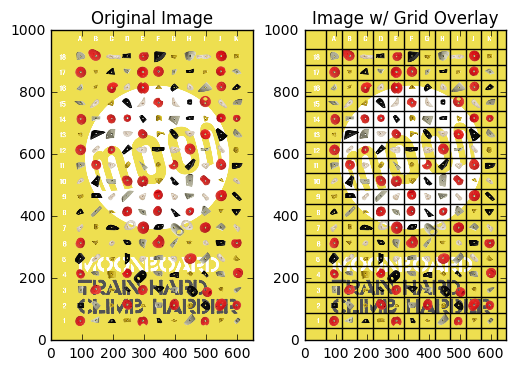

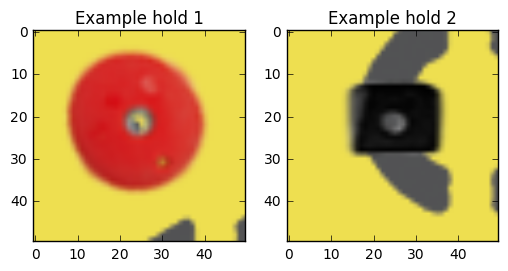

In [40]:
# Going to look at splitting images into sub-images
#plt.title('Base Image')
ax=plt.subplot(121)
plt.title('Original Image')
fig1=plt.imshow(np.flip(image_array.reshape((m,n,4)),0))
plt.ylim(0,1000)
plt.xlim(0,650)
plt.subplot(122)
fig2=plt.imshow(np.flip(image_array.reshape((m,n,4)),0))
plt.title('Image w/ Grid Overlay')
plt.ylim(0,1000)
plt.xlim(0,650)
# Split the image into boxes:
for i in range(12):
    plt.plot([70+i*50,70+i*50],[0,1000],color='k')
for i in range(19):
    plt.plot([0,650],[40+i*50,40+i*50],color='k')
plt.show()
# Create sub-images
plt.subplot(121)
plt.title('Example hold 1')
image_array_2 = np.flip(image_array.reshape((m,n,4)),0)
sub_array = image_array_2[40:90,70:120,:]
fig3=plt.imshow(sub_array)
plt.subplot(122)
plt.title('Example hold 2')
sub_array = image_array_2[90:140,70:120,:]
fig4=plt.imshow(sub_array)
plt.show()

# 8.3.2 Offset Background

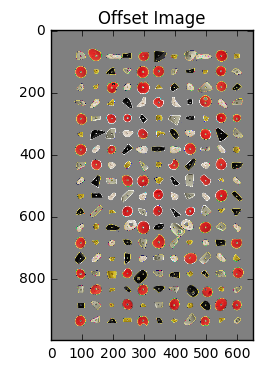

In [41]:
# Open the base image with holds on
image_open = Image.open('{0}'.format(image_file),'r')
image_array1 = np.array(image_open)
n,m = image_open.size
image_open.close()
image_array1 = image_array1.reshape((m*n,4))
image_array1 = image_array1.astype('uint8')
# Open the base image without holds on
image_file_base = 'base_board.png'
image_open = Image.open('{0}'.format(image_file_base),'r')
image_array2 = np.array(image_open)
n,m = image_open.size
image_open.close()
image_array2 = image_array2.reshape((m*n,4))
image_array2 = image_array2.astype('uint8')
plt.title('Offset Image')
image_array1 = np.ravel(image_array1)
image_array1 = image_array1.reshape(-1,1)
image_array2 = np.ravel(image_array2)
image_array2 = image_array2.reshape(-1,1)
#image_array1[np.where(image_array1==image_array2)]=255
image_array_zeros = np.zeros_like(image_array1)
image_array1 = np.where(image_array1==image_array2,image_array_zeros,image_array1)
comparison_array = image_array1.reshape((m*n,4))
image_array2 = image_array2.reshape(m*n,4)
comparison_array = comparison_array[:,:3]
comparison_array = np.concatenate((comparison_array,image_array2[:,3].reshape(-1,1)),axis=1)
comparison_array[(comparison_array[:,0]==0)&(comparison_array[:,1]==0)&(comparison_array[:,2]==0),:]=np.array([128,128,128,255])
fig=plt.imshow(comparison_array.reshape((m,n,4)))

In [42]:
# reshape array to ensure correct
comparison_array = np.flip(comparison_array.reshape(m,n,4),axis=0)

# 8.3.3 Split Image into Sub-images
- split into sub-images
- find centre points
- average the image across pixels

In [43]:
initital_run = True
# create all sub_images
for i in range(11):
    for j in range(18):
        sub_image = comparison_array[40+j*50:40+(1+j)*50,70+i*50:70+(i+1)*50,:]
        mid_point = np.array([np.mean([40+j*50,40+(1+j)*50]),np.mean([70+i*50,70+(i+1)*50])])
        x,y,z = sub_image.shape
        sub_image = sub_image.reshape(x*y,z,1)
        mid_point = mid_point.reshape(-1,1)
        if  initital_run == True:
            output_array = sub_image.copy()
            output_centre_array = mid_point.copy()
            initital_run = False
        else:
            output_array = np.concatenate((output_array,sub_image),axis=2)
            output_centre_array = np.concatenate((output_centre_array,mid_point),axis=1)
# average the pixel values
print('output array shape: {0}'.format(output_array.shape))
# Average across pixels and transpose to dimensions: sub-image x pixel
out_mean = np.mean(output_array,axis=0)
out_mean = out_mean.T

output array shape: (2500, 4, 198)


# 8.3.4 Cluster Image by Pixels

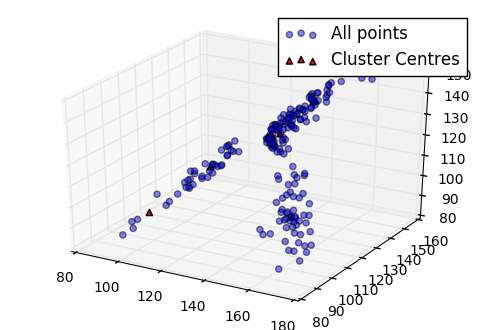

In [44]:
# there are 5 hold types
clustering_model = KMeans(n_clusters=5)
# fit and predict for each sub-image
clustering_model.fit_predict(out_mean)
cluster_ctr = clustering_model.cluster_centers_
fig = plt.figure()
plt.title('Cluster points')
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(out_mean[:,0],out_mean[:,1],out_mean[:,2],alpha=0.5)
ax.scatter3D(cluster_ctr[:,0],cluster_ctr[:,1],cluster_ctr[:,2],c='r',alpha=1,marker='^')
plt.legend(['All points', 'Cluster Centres'])

# 8.3.5 Check Results
The returned classification is not totally accurate, but will be a useful step in adding criteria to the models. The worry is that the model has only really classified 4 types of holds. Some white and yellow holds have been grouped together.

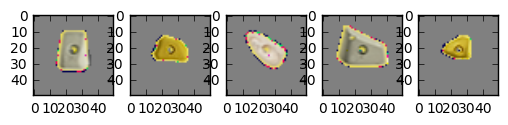

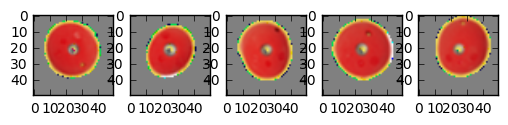

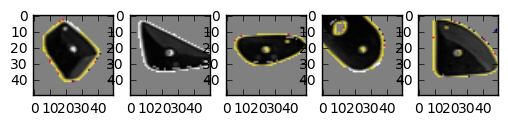

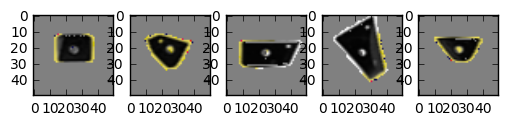

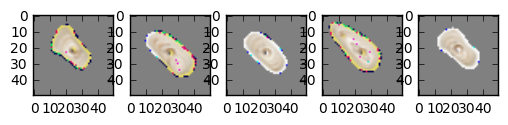

In [45]:
# Look at cluster 0-4
for i in range(5):
    test_array_1 = output_array[:,:,clustering_model.labels_==i]
    for j in range(5):
        plt.subplot(int('15{0}'.format(j+1)))
        sub_array = test_array_1[:,:,j]
        sub_array = sub_array.reshape(50,50,4)
        fig=plt.imshow(sub_array)
    plt.show()


In [46]:
# group the centre points:
centre_point_dic = {}
# centre points logged as y-coordinate,x-coordinate
for i in range(5):
    centre_point_dic[i]=output_centre_array[:,clustering_model.labels_==i].T

# 8.3.6 Add to Stored Data
Iterate over all images, and holds within the image. Find the closest hold type for each hold and add this to the base data.

In [53]:
data.head()

,FileName,Name,Grade,Hyperlink,V_Grades,red,green,blue,total_holds,Max_dist,Mean_dist,Std_dist,Mean_angle
0,0.png,#222 DYNAMIC STRETCH (3Q),6B+,https://www.moonboard.com/Problems/View/312855...,5,1,2,4,7,290.549771,187.423348,64.364963,48.112716
1,1.png,1 ARM MADNESS (MBMASTERS),8A+,https://www.moonboard.com/Problems/View/308170...,12,1,2,3,6,350.000000,209.754668,94.876301,56.530663
2,2.png,32.2 MILES,6C,https://www.moonboard.com/Problems/View/315586...,5,1,2,4,7,290.497903,212.382989,74.022871,37.280444
3,3.png,52KIMCHI,7C+,https://www.moonboard.com/Problems/View/316811...,10,1,2,4,7,321.441546,183.558514,84.720412,37.251570
4,4.png,7B THEY SAID...,7A,https://www.moonboard.com/Problems/View/308629...,6,1,2,6,9,268.503487,183.713543,68.648450,26.573449


In [56]:
additional_data = {'hold_type_{0}'.format(x):[] for x in range(0,5)}
for image_name in data['FileName']:    
    # step 1 load image
    image_open = Image.open("{0}\\{1}".format(path,image_name))
    image_data = np.array(image_open.getdata())
    # create relevant dictionaries for colours
    rgb_dic = {'red' : [255,0,0,255],'green' : [0,255,0,255],'blue' : [0,0,255,255]}
    # step 2 create binary array of image
    image_binary = np.zeros(len(image_data))
    for key in rgb_dic.keys():
        image_binary[(image_data[:,0]==rgb_dic[key][0])&(image_data[:,1]==rgb_dic[key][1])&(image_data[:,2]==rgb_dic[key][2]) & (image_data[:,3]==rgb_dic[key][3])]=1
    image_binary  = image_binary.reshape(image_open.height,image_open.width)
    # step 3 locate centre of each cluster
    # fit the pixel locations to a KMeans clustering model to find centre points
    y,x=np.where(image_binary==1)
    m=x.size
    x=x.reshape(m,1)
    y=y.reshape(m,1)
    YX=np.concatenate((y,x),axis=1)
    hold_number=int(data[data['FileName']==image_name]['total_holds'])
    hold_kmeans=KMeans(n_clusters=hold_number)
    hold_kmeans.fit(YX)
    hold_kmeans.cluster_centers_
    centres_dic = {x:0 for x in range(5)}
    for centre in hold_kmeans.cluster_centers_:
        closest_point = float('inf')
        hold_group = 99
        for group in centre_point_dic.keys():
            closest_in_group = np.min(np.sqrt(np.sum(np.power(np.abs(centre_point_dic[group]-centre),2),axis=1)))
            if closest_in_group < closest_point:
                hold_group = group
                closest_point = closest_in_group
        centres_dic[hold_group]+=1
    for key in centres_dic.keys():
        additional_data['hold_type_{0}'.format(key)].append(centres_dic[key])
    image_open.close()
print('Additional data created')
data=pd.concat((data,pd.DataFrame(additional_data)),axis=1)
data.to_excel('BaselineProblems.xlsm')

Additional data created


# 8.3.7 Retest Logistic Regression
Additional data does not yield a more accurate regression model.

In [57]:
training_df = data[['total_holds','Max_dist','Mean_dist','Std_dist','Mean_angle','hold_type_0','hold_type_1','hold_type_2','hold_type_3','hold_type_4']]
training_grade_df = data['V_Grades']

In [58]:
logistic_regression = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(training_df, training_grade_df, test_size=0.33, random_state=42)
logistic_regression.fit(X_train,y_train)
prediction = logistic_regression.predict(X_test)
print('accuracy score: {0}'.format(accuracy_score(y_test,prediction)))

accuracy score: 0.2857142857142857
